In [42]:
import sys

sys.path.insert(0, '/home/shenwanxiang/Research/aliyun_sync/COMPASS/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, score2
from compass.tokenizer import CANCER_CODE
from sklearn.metrics import roc_curve, auc
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

lmp = {'PFT': 'Compass' + '-PFT',
 'LFT': 'Compass' + '-LFT',
 'FFT': 'Compass' + '-FFT',
 'NetBio': 'NetBio',
 'Teff': 'Teff',
 'CD8': 'CD8',
 'CTL': 'CTL',
 'CIS': 'CIS',
 'IS': 'IS',
 'ICA': 'ICA',
 'PDL1': 'PDL1',
 'PGM': 'PGM',
 'CKS': 'CKS',
 'PD1': 'PD1',
 'TIDE': 'TIDE',
 'GeneBio': 'GeneBio',
 'TAM': 'TAM',
 'NFT': 'Compass' + '-NFT',
 'CTLA4': 'CTLA4',
 'IMPRES': 'IMPRES',
 'GEP': 'GEP',
 'CAF': 'CAF',
 'Texh': 'Texh',
 'IFNG': 'IFNG',
 'MIAS': 'MIAS',
 'NRS': 'NRS'}

    
def plot_grouped_prc_auc(dfp, color_map, method_order):

    grouped = dfp.groupby('size_map')

    fig, axes = plt.subplots(figsize=(12, 7), ncols=3)
    
    for (group_name, group_data ), ax in zip(grouped, axes):
        
        
        # 添加随机分类器 baseline
        positive_ratio = group_data['R'].sum() / len(group_data['R'])
        ax.hlines(y=positive_ratio, xmin=0, xmax=1,
                  colors='gray', linestyles='dashed') #, label='Random baseline'

        methods = group_data['mode'].unique()
        
        for method in method_order:
            method_data = group_data[group_data['mode'] == method]
            seeds = method_data['seed'].unique()
            precision_list, ap_list = [], []

            for seed in seeds:
                seed_data = method_data[method_data['seed'] == seed]
                if len(seed_data['R'].unique()) < 2:
                    continue  # Skip if only one class present
                precision, recall, _ = precision_recall_curve(seed_data['R'], seed_data['1'])
                ap = average_precision_score(seed_data['R'], seed_data['1'])
                precision_interp = np.interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1])
                precision_list.append(precision_interp)
                ap_list.append(ap)

            if len(precision_list) == 0:
                continue

            mean_precision = np.mean(precision_list, axis=0)
            std_precision = np.std(precision_list, axis=0)
            mean_ap = np.mean(ap_list)

            ax.plot(np.linspace(0, 1, 100), mean_precision,
                    label=f'{method} (AP = {mean_ap:.2f})',
                    color=color_map.get(method, 'black'))

            ax.fill_between(np.linspace(0, 1, 100),
                            mean_precision - std_precision,
                            mean_precision + std_precision,
                            color=color_map.get(method, 'black'),
                            alpha=0.2)

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall Curve\n ({group_name} group)')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), frameon=False)
    fig.tight_layout()
    return fig

def plot_grouped_roc(dfp, color_map, method_order):

    grouped = dfp.groupby('size_map')
    fig, axes = plt.subplots(figsize=(12, 7), ncols=3)
    
    for (group_name, group_data ), ax in zip(grouped, axes):

        methods = group_data['mode'].unique()
        
        for method in method_order:
            method_data = group_data[group_data['mode'] == method]
            seeds = method_data['seed'].unique()
            fpr_list, tpr_list, auc_list = [], [], []

            for seed in seeds:
                seed_data = method_data[method_data['seed'] == seed]
                fpr, tpr, _ = roc_curve(seed_data['R'], seed_data['1'])
                roc_auc = auc(fpr, tpr)
                fpr_list.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))
                tpr_list.append(tpr)
                auc_list.append(roc_auc)

            mean_tpr = np.mean(fpr_list, axis=0)
            std_tpr = np.std(fpr_list, axis=0)
            mean_auc = np.mean(auc_list)

            ax.plot(np.linspace(0, 1, 100), mean_tpr,
                    label=f'{method} (AUC = {mean_auc:.2f})',
                    color=color_map.get(method, 'black'))

            ax.fill_between(np.linspace(0, 1, 100),
                            mean_tpr - std_tpr,
                            mean_tpr + std_tpr,
                            color=color_map.get(method, 'black'),
                            alpha=0.2)

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve\n ({group_name} group)')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), frameon=False)
    fig.tight_layout()
    return fig

In [56]:
modes = [ 'Compass-PFT', 'NetBio', 'PGM','Teff', 'GEP', 'TIDE'] #'LFT', 'TIDE', 

colors = sns.color_palette('gnuplot', len(modes)).as_hex()

colors

['#6001c6', '#8806f8', '#a71470', '#c13000', '#d75d00', '#eca200']

In [57]:
color_map = dict(zip(modes, colors))
compass_cmap = {'Compass-PFT':'#36AFCE', 'Compass-LFT':'#86CFE2',
                'Compass-FFT':'#AFDFEB','Compass-NFT':'#D7EFF5', }
color_map.update(compass_cmap)

In [58]:
data = pd.read_csv('./LOCO_raw_data.csv', index_col=0)
data['mode'] = data['mode'].map(lmp)
dfp = data[data['mode'].isin(modes)]

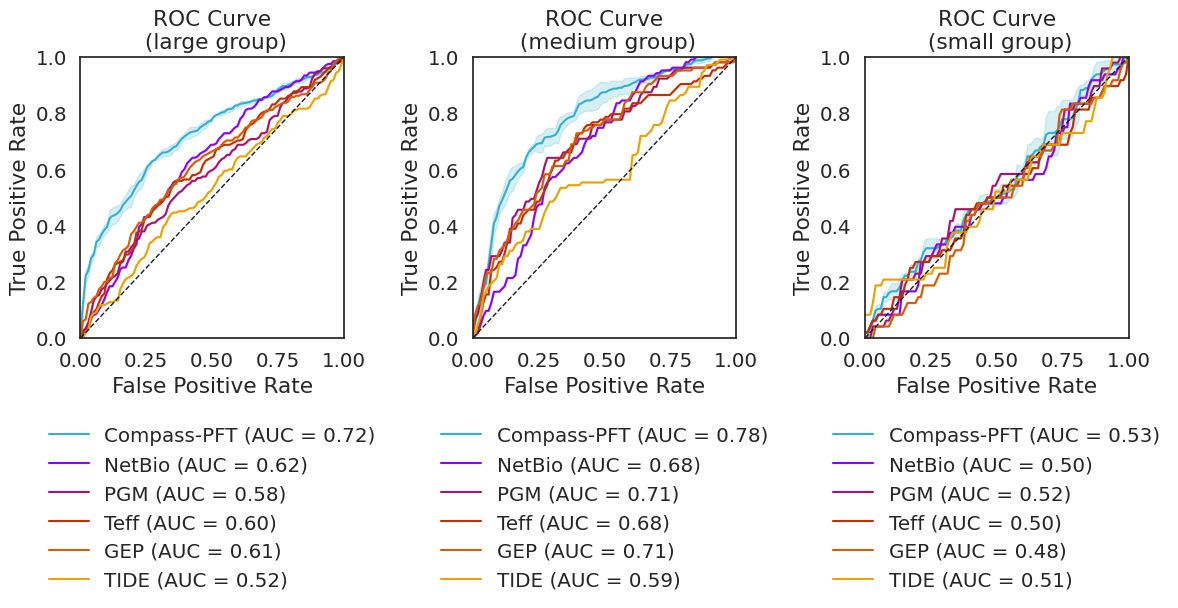

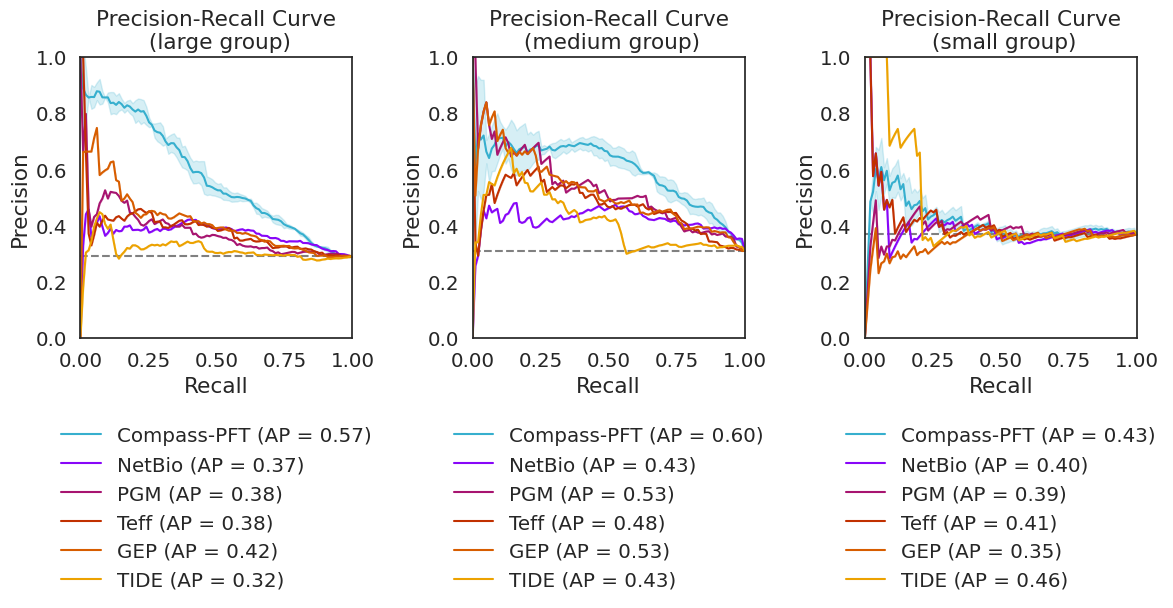

In [59]:
fig1 = plot_grouped_roc(dfp, color_map, method_order = modes)
fig2 = plot_grouped_prc_auc(dfp, color_map, method_order = modes)

In [60]:
fig1.savefig('grouped_roc.svg', bbox_inches = 'tight',dpi = 300)
fig2.savefig('grouped_prc.svg', bbox_inches = 'tight',dpi = 300)